In [32]:
!pip install tensorly
!pip install lifelines

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac
from tensorly.decomposition import non_negative_parafac

# Load your data
methylation_df = pd.read_excel('/content/drive/MyDrive/5703/TCGA-BRCA/Methylation_ENCODER.xlsx').set_index('attrib_name')
rnaseq_df = pd.read_excel('/content/drive/MyDrive/5703/TCGA-BRCA/RNAseq_ENCODER.xlsx').set_index('attrib_name')
mirna_df = pd.read_excel('/content/drive/MyDrive/5703/TCGA-BRCA/miRNASeq_ENCODER.xlsx').set_index('attrib_name')
image_df = pd.read_csv('/content/drive/MyDrive/5703/TCGA-BRCA/all_images_BRAC_128_filtered.csv').set_index('attrib_name')

# Join dataframes based on the index
merged_data = methylation_df.join([rnaseq_df, mirna_df, image_df], how='inner')

# Extract aligned datasets
methylation_data_aligned = merged_data[methylation_df.columns].to_numpy()
rnaseq_data_aligned = merged_data[rnaseq_df.columns].to_numpy()
mirna_data_aligned = merged_data[mirna_df.columns].to_numpy()
image_data_aligned = merged_data[image_df.columns].to_numpy()

# Create the 3D tensor
multi_omics_tensor = np.array([methylation_data_aligned, rnaseq_data_aligned, mirna_data_aligned, image_data_aligned], dtype=object)

# Reorder the tensor
multi_omics_tensor_transposed = np.transpose(multi_omics_tensor, (1, 0, 2))
multi_omics_tensor_transposed = multi_omics_tensor_transposed.astype(np.float64)

# Store the indexes
sample_indexes = merged_data.index.tolist()

print(multi_omics_tensor_transposed.shape)
print(sample_indexes)


(622, 4, 128)
['TCGA.3C.AAAU', 'TCGA.3C.AAAU', 'TCGA.3C.AALI', 'TCGA.3C.AALJ', 'TCGA.3C.AALK', 'TCGA.4H.AAAK', 'TCGA.5L.AAT0', 'TCGA.5L.AAT1', 'TCGA.5T.A9QA', 'TCGA.A1.A0SB', 'TCGA.A1.A0SF', 'TCGA.A1.A0SG', 'TCGA.A1.A0SI', 'TCGA.A1.A0SN', 'TCGA.A1.A0SQ', 'TCGA.A2.A0CK', 'TCGA.A2.A0CO', 'TCGA.A2.A0CR', 'TCGA.A2.A0EP', 'TCGA.A2.A1FV', 'TCGA.A2.A1FW', 'TCGA.A2.A1FX', 'TCGA.A2.A1FZ', 'TCGA.A2.A1G0', 'TCGA.A2.A1G1', 'TCGA.A2.A1G4', 'TCGA.A2.A1G6', 'TCGA.A2.A259', 'TCGA.A2.A25A', 'TCGA.A2.A25B', 'TCGA.A2.A25C', 'TCGA.A2.A25D', 'TCGA.A2.A25E', 'TCGA.A2.A25F', 'TCGA.A2.A3KC', 'TCGA.A2.A3KD', 'TCGA.A2.A3XS', 'TCGA.A2.A3XT', 'TCGA.A2.A3XU', 'TCGA.A2.A3XV', 'TCGA.A2.A3XW', 'TCGA.A2.A3XX', 'TCGA.A2.A3XY', 'TCGA.A2.A3XZ', 'TCGA.A2.A3Y0', 'TCGA.A2.A4RW', 'TCGA.A2.A4RX', 'TCGA.A2.A4RY', 'TCGA.A2.A4S0', 'TCGA.A2.A4S1', 'TCGA.A2.A4S2', 'TCGA.A2.A4S3', 'TCGA.A7.A13D', 'TCGA.A7.A13E', 'TCGA.A7.A13F', 'TCGA.A7.A13G', 'TCGA.A7.A13H', 'TCGA.A7.A26E', 'TCGA.A7.A26F', 'TCGA.A7.A26G', 'TCGA.A7.A26H', 'TCGA.A7.

In [35]:


# CP decomposition
rank = 3 # the rank of CP decomposition, which can be motified
factors = parafac(multi_omics_tensor_transposed, rank=rank)

print(factors)

# obtain weights and factors
weights = factors[0]
factor_matrices = factors[1]  # This is a list that contains 3 factors array

# patient’s mode
patient_mode_matrix = factor_matrices[0]
print(patient_mode_matrix.shape)
# omics feature mode
omics_feature_mode_matrix = factor_matrices[1]
print(omics_feature_mode_matrix.shape)
# genes mode
genes_mode_matrix = factor_matrices[2]
print(genes_mode_matrix.shape)

(weights, factors) : rank-3 CPTensor of shape (622, 4, 128)
(622, 3)
(4, 3)
(128, 3)


In [36]:
# Convert patient_mode_matrix to a DataFrame with index
patient_df = pd.DataFrame(patient_mode_matrix, index=sample_indexes)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
from scipy.cluster.hierarchy import linkage, fcluster

# 1. import clinical.xlsx
data_methylation = pd.read_excel('/content/drive/MyDrive/5703/TCGA-BRCA/Methylation_ENCODER.xlsx')
data_clinical = pd.read_excel('/content/drive/MyDrive/5703/TCGA-BRCA/Clinical.xlsx')
selected_samples = data_methylation.iloc[:, 0].unique()
data = data_clinical[data_clinical['attrib_name'].isin(selected_samples)]
data.fillna(0, inplace=True)



# Merge the two dataframes on the 'attrib_name' column and the index of patient_df
merged_data = pd.merge(data, patient_df, left_on='attrib_name', right_index=True)

# The result will be a dataframe where each row contains both the clinical data and the corresponding patient_mode_matrix values.



<ipython-input-37-5ab78cbda4cc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


In [38]:
merged_data

,attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,number_of_lymph_nodes,PAM50,...,radiation_therapy,race,ethnicity,Median_overall_survival,overall_survival,status,overallsurvival,0,1,2
0,TCGA.5L.AAT0,42.0,0.6501,stageii,t2,n0,m0,infiltratinglobularcarcinoma,0.0,0,...,yes,white,hispanicorlatino,0.0,1477.0,0.0,"1477,0",17.057327,10.596300,6.189595e-16
1,TCGA.5L.AAT1,63.0,0.5553,stageiv,t2,n0,m1,infiltratinglobularcarcinoma,0.0,0,...,no,white,hispanicorlatino,0.0,1471.0,0.0,"1471,0",16.127804,10.773936,3.833198e-16
6,TCGA.A2.A1G4,71.0,0.8879,stageiii,t3,n1,m0,infiltratingductalcarcinoma,2.0,LumB,...,no,white,nothispanicorlatino,0.0,595.0,0.0,"595,0",18.335260,10.539193,-4.970575e-16
7,TCGA.A2.A25A,44.0,0.5950,stageii,t2,n0,m0,infiltratinglobularcarcinoma,0.0,0,...,yes,white,nothispanicorlatino,0.0,3276.0,0.0,"3276,0",16.642806,10.809458,7.814839e-16
9,TCGA.A7.A13G,79.0,0.9357,stageii,t2,n0,0,infiltratingductalcarcinoma,0.0,LumA,...,no,white,nothispanicorlatino,0.0,718.0,0.0,"718,0",19.464457,-0.083591,-2.056266e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,TCGA.V7.A7HQ,75.0,0.7774,stageiii,t1,n2,m0,infiltratingductalcarcinoma,5.0,0,...,yes,blackorafricanamerican,nothispanicorlatino,0.0,2033.0,0.0,"2033,0",15.716841,10.862948,3.463456e-16
1093,TCGA.WT.AB44,0.0,0.7493,stagei,t1,n0,0,infiltratinglobularcarcinoma,0.0,0,...,yes,white,nothispanicorlatino,0.0,883.0,0.0,"883,0",16.705763,10.826372,4.111635e-16
1094,TCGA.XX.A899,46.0,0.6069,stageiii,t1,n2,0,infiltratinglobularcarcinoma,5.0,0,...,yes,white,nothispanicorlatino,0.0,467.0,0.0,"467,0",16.379847,8.962696,6.252945e-16
1095,TCGA.XX.A89A,68.0,0.6067,stageii,t3,n0,0,infiltratinglobularcarcinoma,0.0,0,...,yes,white,nothispanicorlatino,0.0,488.0,0.0,"488,0",15.462442,10.477279,4.193891e-16


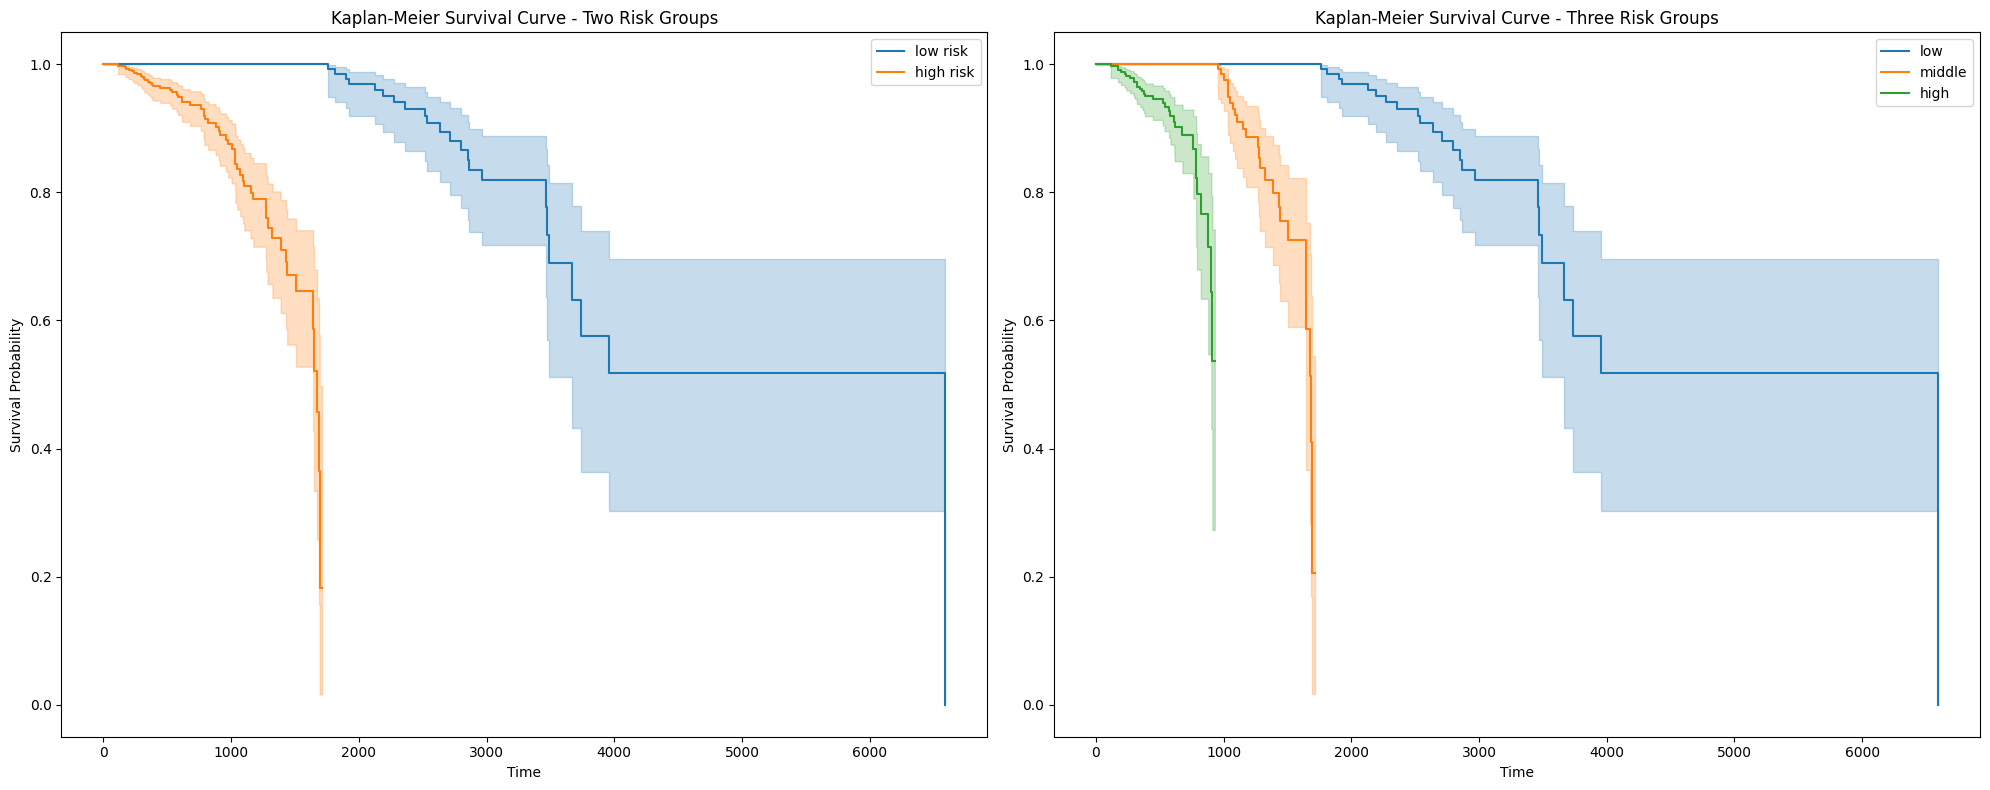

In [39]:
#这一版本在cluttering的时候使用了overall_survival以及status，造成了overfiting，所以模型表现非常好

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from lifelines import KaplanMeierFitter

# 除去非数值列，以进行Hierarchical clustering
numeric_data = merged_data.select_dtypes(include=[np.number])

# 使用Hierarchical clustering进行分组
linked = linkage(numeric_data, 'ward')

# 创建两个和三个风险组
label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')

# 将merged_data复制到新变量processed_data
processed_data = merged_data.copy()

# 将这些标签添加到新数据集中
processed_data['risk_group_2'] = label_2_clusters
processed_data['risk_group_3'] = label_3_clusters

# 初始化KaplanMeierFitter对象
kmf = KaplanMeierFitter()

# 对两个风险组进行Kaplan-Meier生存分析
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "low risk", 2: "high risk"}
for label in np.unique(label_2_clusters):
    mask = processed_data['risk_group_2'] == label
    group_data = processed_data[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.subplot(1, 2, 2)
risk_labels_3 = {1: "low", 2: "middle", 3: "high"}
for label in np.unique(label_3_clusters):
    mask = processed_data['risk_group_3'] == label
    group_data = processed_data[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()





In [40]:

from lifelines.statistics import logrank_test

group1 = processed_data[processed_data['risk_group_2'] == 1]
group2 = processed_data[processed_data['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value for the difference between two risk groups: {p_value_2}")

group1 = processed_data[processed_data['risk_group_3'] == 1]
group2 = processed_data[processed_data['risk_group_3'] == 2]
group3 = processed_data[processed_data['risk_group_3'] == 3]

results_3_12 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
results_3_13 = logrank_test(group1['overall_survival'], group3['overall_survival'], event_observed_A=group1['status'], event_observed_B=group3['status'])
results_3_23 = logrank_test(group2['overall_survival'], group3['overall_survival'], event_observed_A=group2['status'], event_observed_B=group3['status'])

print(f"P-value for the difference between risk groups 1 and 2: {results_3_12.p_value}")
print(f"P-value for the difference between risk groups 1 and 3: {results_3_13.p_value}")
print(f"P-value for the difference between risk groups 2 and 3: {results_3_23.p_value}")

P-value for the difference between two risk groups: 6.323643685667907e-17
P-value for the difference between risk groups 1 and 2: 1.0320350539768737e-16
P-value for the difference between risk groups 1 and 3: 3.053268735428492e-10
P-value for the difference between risk groups 2 and 3: 5.186983734185432e-10


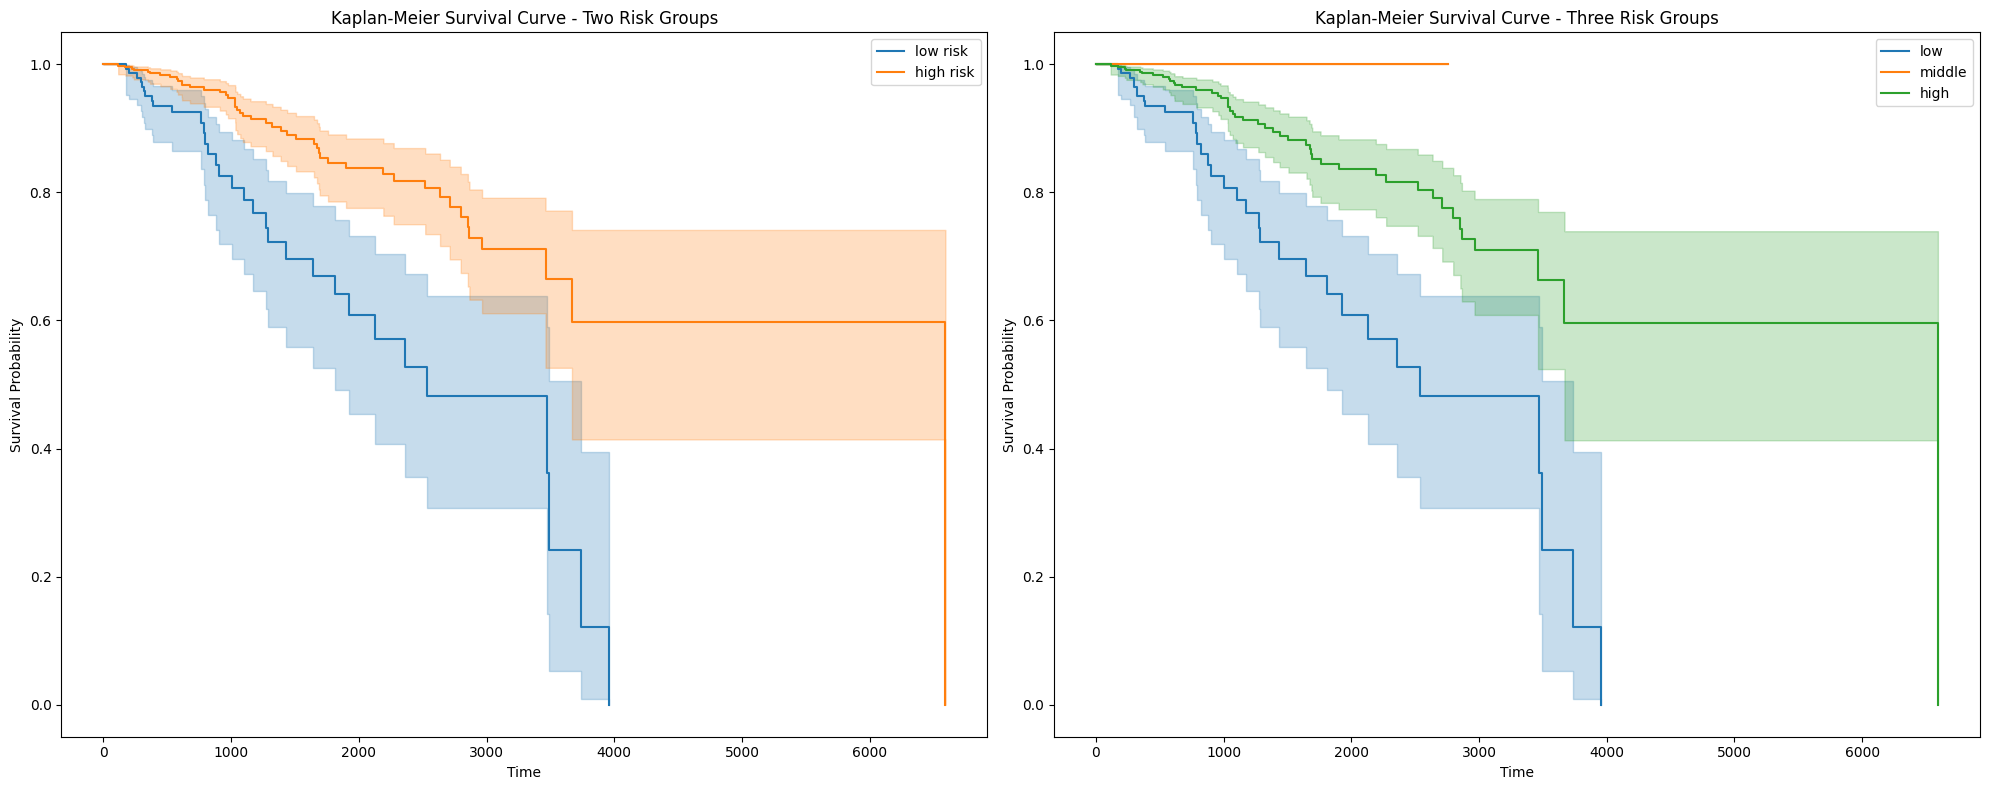

In [41]:

new_df = merged_data.drop(columns=['overall_survival', 'status',"Median_overall_survival"])
numeric_data_new = new_df.select_dtypes(include=[np.number])

linked = linkage(numeric_data_new, 'ward')

label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')

processed_data_new = merged_data.copy()

processed_data_new['risk_group_2'] = label_2_clusters
processed_data_new['risk_group_3'] = label_3_clusters

kmf = KaplanMeierFitter()

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "low risk", 2: "high risk"}
for label in np.unique(label_2_clusters):
    mask = processed_data_new['risk_group_2'] == label
    group_data = processed_data_new[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.subplot(1, 2, 2)
risk_labels_3 = {1: "low", 2: "middle", 3: "high"}
for label in np.unique(label_3_clusters):
    mask = processed_data_new['risk_group_3'] == label
    group_data = processed_data_new[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()



In [42]:
from lifelines.statistics import logrank_test

group1 = processed_data_new[processed_data_new['risk_group_2'] == 1]
group2 = processed_data_new[processed_data_new['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value for the difference between two risk groups: {p_value_2}")

group1 = processed_data_new[processed_data_new['risk_group_3'] == 1]
group2 = processed_data_new[processed_data_new['risk_group_3'] == 2]
group3 = processed_data_new[processed_data_new['risk_group_3'] == 3]

results_3_12 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
results_3_13 = logrank_test(group1['overall_survival'], group3['overall_survival'], event_observed_A=group1['status'], event_observed_B=group3['status'])
results_3_23 = logrank_test(group2['overall_survival'], group3['overall_survival'], event_observed_A=group2['status'], event_observed_B=group3['status'])

print(f"P-value for the difference between risk groups 1 and 2: {results_3_12.p_value}")
print(f"P-value for the difference between risk groups 1 and 3: {results_3_13.p_value}")
print(f"P-value for the difference between risk groups 2 and 3: {results_3_23.p_value}")

P-value for the difference between two risk groups: 5.714204480516997e-07
P-value for the difference between risk groups 1 and 2: 0.1843358225338742
P-value for the difference between risk groups 1 and 3: 7.991607365124631e-07
P-value for the difference between risk groups 2 and 3: 0.4616344680017479


<ipython-input-43-3d1a8a98bbd4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['risk_group_2'] = label_2_clusters
<ipython-input-43-3d1a8a98bbd4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['risk_group_3'] = label_3_clusters


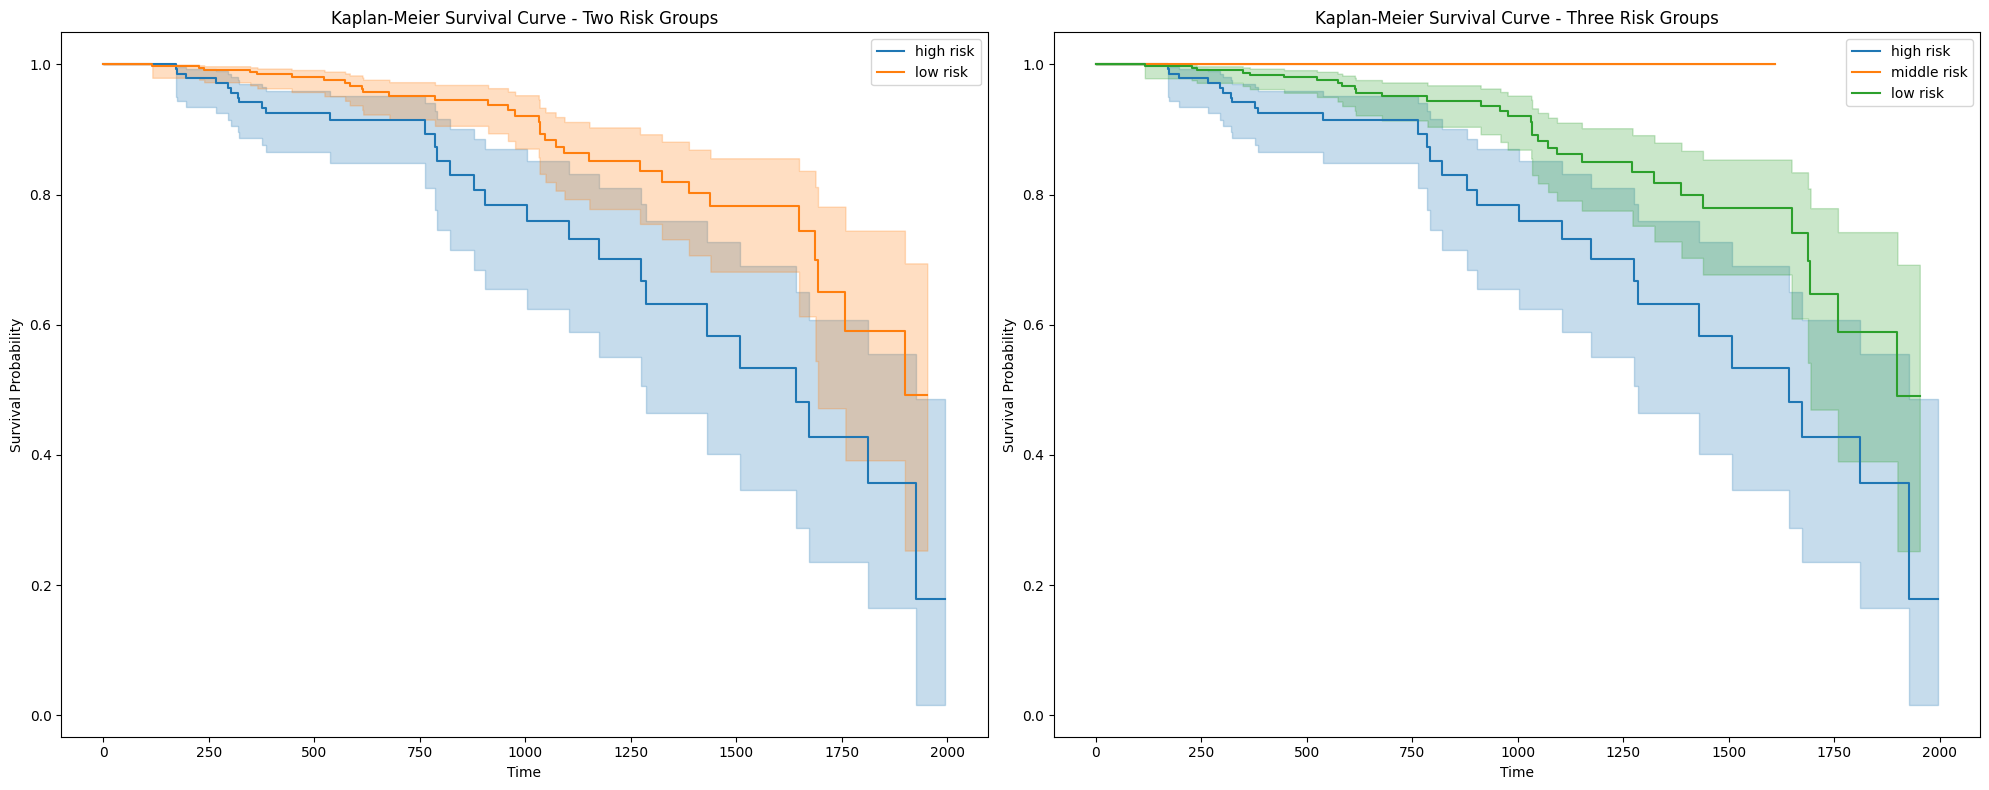

In [43]:

filtered_df = merged_data[merged_data['overall_survival'] < 2000]


new_df = filtered_df.drop(columns=['overall_survival', 'status',"Median_overall_survival"])
numeric_data_new = new_df.select_dtypes(include=[np.number])

linked = linkage(numeric_data_new, 'ward')


label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')



filtered_df['risk_group_2'] = label_2_clusters
filtered_df['risk_group_3'] = label_3_clusters

kmf = KaplanMeierFitter()

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "high risk", 2: "low risk"}
for label in np.unique(label_2_clusters):
    mask = filtered_df['risk_group_2'] == label
    group_data = filtered_df[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')


plt.subplot(1, 2, 2)
risk_labels_3 = {1: "high risk", 2: "middle risk", 3: "low risk"}
for label in np.unique(label_3_clusters):
    mask = filtered_df['risk_group_3'] == label
    group_data = filtered_df[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()


In [44]:
from lifelines.statistics import logrank_test


group1 = filtered_df[filtered_df['risk_group_2'] == 1]
group2 = filtered_df[filtered_df['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value for the difference between two risk groups: {p_value_2}")

P-value for the difference between two risk groups: 0.0005049232225941644


In [45]:
filtered_df

,attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,number_of_lymph_nodes,PAM50,...,ethnicity,Median_overall_survival,overall_survival,status,overallsurvival,0,1,2,risk_group_2,risk_group_3
0,TCGA.5L.AAT0,42.0,0.6501,stageii,t2,n0,m0,infiltratinglobularcarcinoma,0.0,0,...,hispanicorlatino,0.0,1477.0,0.0,"1477,0",17.057327,10.596300,6.189595e-16,2,3
1,TCGA.5L.AAT1,63.0,0.5553,stageiv,t2,n0,m1,infiltratinglobularcarcinoma,0.0,0,...,hispanicorlatino,0.0,1471.0,0.0,"1471,0",16.127804,10.773936,3.833198e-16,2,3
6,TCGA.A2.A1G4,71.0,0.8879,stageiii,t3,n1,m0,infiltratingductalcarcinoma,2.0,LumB,...,nothispanicorlatino,0.0,595.0,0.0,"595,0",18.335260,10.539193,-4.970575e-16,1,1
9,TCGA.A7.A13G,79.0,0.9357,stageii,t2,n0,0,infiltratingductalcarcinoma,0.0,LumA,...,nothispanicorlatino,0.0,718.0,0.0,"718,0",19.464457,-0.083591,-2.056266e-16,1,1
10,TCGA.A7.A26E,71.0,0.7913,stageiii,t3,n1,0,infiltratinglobularcarcinoma,0.0,LumA,...,nothispanicorlatino,0.0,954.0,0.0,"954,0",18.120162,10.743249,5.154313e-16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,TCGA.UL.AAZ6,73.0,0.8031,stageii,t2,n0,0,infiltratingductalcarcinoma,0.0,0,...,nothispanicorlatino,0.0,518.0,0.0,"518,0",16.231821,10.418562,4.689537e-17,1,1
1091,TCGA.UU.A93S,63.0,0.8339,stageiv,t4,n3,m1,infiltratingductalcarcinoma,0.0,0,...,nothispanicorlatino,0.0,116.0,1.0,"116,1",15.318376,9.256663,3.748888e-16,2,3
1093,TCGA.WT.AB44,0.0,0.7493,stagei,t1,n0,0,infiltratinglobularcarcinoma,0.0,0,...,nothispanicorlatino,0.0,883.0,0.0,"883,0",16.705763,10.826372,4.111635e-16,2,2
1094,TCGA.XX.A899,46.0,0.6069,stageiii,t1,n2,0,infiltratinglobularcarcinoma,5.0,0,...,nothispanicorlatino,0.0,467.0,0.0,"467,0",16.379847,8.962696,6.252945e-16,2,3


In [109]:
methylation_df = pd.read_csv('/content/drive/MyDrive/5703/TCGA-BRCA/Methylation__Meth450_128.csv')
rnaseq_df = pd.read_csv('/content/drive/MyDrive/5703/TCGA-BRCA/RNAseq__HiSeq_RNA_128.csv')
mirna_df = pd.read_csv('/content/drive/MyDrive/5703/TCGA-BRCA/miRNASeq__HS_miR_128.csv')
image_df = pd.read_csv('/content/drive/MyDrive/5703/TCGA-BRCA/all_images_BRAC_128_filtered.csv')

Clinical_df = pd.read_csv('/content/drive/MyDrive/5703/TCGA-BRCA/Clinical.csv')

kmeans_df = pd.merge(methylation_df, rnaseq_df, on="attrib_name", how="inner")
kmeans_df = pd.merge(kmeans_df, mirna_df, on="attrib_name", how="inner")
#kmeans_df = pd.merge(kmeans_df, image_df, on="attrib_name", how="inner")

kmeans_df.columns = kmeans_df.columns.astype(str)
kmeans_df

,attrib_name,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,118,119,120,121,122,123,124,125,126,127
0,TCGA.3C.AAAU,14.625108,0.000000,0.0,8.790771,0.0,0.0,0.0,0.0,10.209114,...,0.622166,0.038883,0.0,0.496235,0.0,0.0,0.0,0.0,0.953027,0.0
1,TCGA.3C.AALI,15.384162,2.610127,0.0,6.576795,0.0,0.0,0.0,0.0,0.000000,...,0.706692,1.233945,0.0,0.190356,0.0,0.0,0.0,0.0,1.737383,0.0
2,TCGA.3C.AALJ,12.510753,0.000000,0.0,4.793648,0.0,0.0,0.0,0.0,0.505122,...,0.381248,0.403755,0.0,0.000000,0.0,0.0,0.0,0.0,2.034071,0.0
3,TCGA.3C.AALK,19.158442,0.000000,0.0,4.066125,0.0,0.0,0.0,0.0,2.295568,...,0.396657,0.636511,0.0,0.000000,0.0,0.0,0.0,0.0,2.179386,0.0
4,TCGA.4H.AAAK,21.311453,0.000000,0.0,7.159411,0.0,0.0,0.0,0.0,6.108991,...,0.620262,0.097861,0.0,0.000000,0.0,0.0,0.0,0.0,2.715928,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,TCGA.WT.AB44,26.277332,0.000000,0.0,5.629574,0.0,0.0,0.0,0.0,4.339798,...,0.139473,0.303144,0.0,0.000000,0.0,0.0,0.0,0.0,2.280053,0.0
617,TCGA.XX.A899,15.551846,6.309134,0.0,3.641717,0.0,0.0,0.0,0.0,6.995820,...,0.830286,1.039893,0.0,0.575704,0.0,0.0,0.0,0.0,2.063425,0.0
618,TCGA.XX.A89A,9.584288,8.129096,0.0,6.884301,0.0,0.0,0.0,0.0,7.602070,...,0.565569,1.464523,0.0,0.002846,0.0,0.0,0.0,0.0,1.766279,0.0
619,TCGA.Z7.A8R5,19.851770,1.451877,0.0,6.806647,0.0,0.0,0.0,0.0,4.852437,...,0.159072,0.709140,0.0,0.475601,0.0,0.0,0.0,0.0,2.046999,0.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


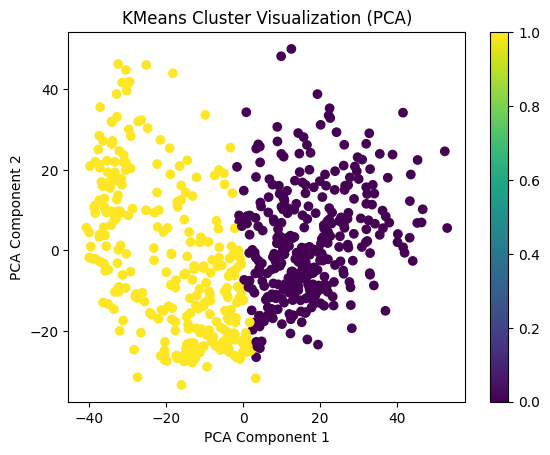

In [110]:
from sklearn.cluster import KMeans

# Specify the number of clusters you want to create
num_clusters = 2  # 4 stages

# Initialize the K-Means clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the K-Means model to the reduced-dimensional data
cluster_labels = kmeans.fit_predict(kmeans_df.iloc[:, 1:])
#cluster_labels = kmeans.fit_predict(scaled_data)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_df.iloc[:, 1:])
#X_pca = pca.fit_transform(scaled_data)
# Create a scatter plot of the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('KMeans Cluster Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

In [111]:
kmeans_result = pd.DataFrame()
kmeans_result["attrib_name"] = kmeans_df["attrib_name"]
kmeans_result["cluster"] = cluster_labels
kmeans_result

,attrib_name,cluster
0,TCGA.3C.AAAU,0
1,TCGA.3C.AALI,1
2,TCGA.3C.AALJ,1
3,TCGA.3C.AALK,1
4,TCGA.4H.AAAK,0
...,...,...
616,TCGA.WT.AB44,0
617,TCGA.XX.A899,1
618,TCGA.XX.A89A,1
619,TCGA.Z7.A8R5,1


In [112]:
kmeans_risk = pd.merge(kmeans_result, filtered_df, on="attrib_name")


In [113]:
attributes = [
    'pathologic_stage',
    'pathology_N_stage',
    'pathology_M_stage',
    'pathology_T_stage',
    'PAM50',
    'ER.Status',
    'PR.Status',
    'HER2.Status',
    'pathology_T_stage',
    'number_of_lymph_nodes',
    'radiation_therapy',
    'risk_group_2',
    'risk_group_3'
]

for attribute in attributes:
    stage_counts = kmeans_risk.groupby('cluster')[attribute].value_counts()
    stage_counts = stage_counts.unstack(fill_value=0)
    print(stage_counts)

pathologic_stage  0  stagei  stageii  stageiii  stageiv
cluster                                                
0                 2      40      147        80        2
1                 0      37      143        49        5
pathology_N_stage  0   n0   n1  n2  n3
cluster                               
0                  5  110  102  33  21
1                  1  122   69  20  22
pathology_M_stage   0   m0  m1
cluster                       
0                  73  196   2
1                  65  164   5
pathology_T_stage  t1   t2  t3  t4
cluster                           
0                  67  150  42  12
1                  57  145  26   6
PAM50     0  Basal  Her2  LumA  LumB
cluster                             
0        57      0     6   134    74
1        97     55    20    51    11
ER.Status    0  Positive
cluster                 
0          268         3
1          234         0
PR.Status    0  Positive
cluster                 
0          268         3
1          234         0
HER2.Sta

#Evaluate k-means results



k: 1 SSE: 4780.034586558266
k: 2 SSE: 3245.4259910945802
k: 3 SSE: 1748.0358366988721
k: 4 SSE: 1316.5078457443315
k: 5 SSE: 921.9479979316462
k: 6 SSE: 706.12880770962
k: 7 SSE: 584.8800738572977
k: 8 SSE: 495.784172309757
k: 9 SSE: 422.57011728614407


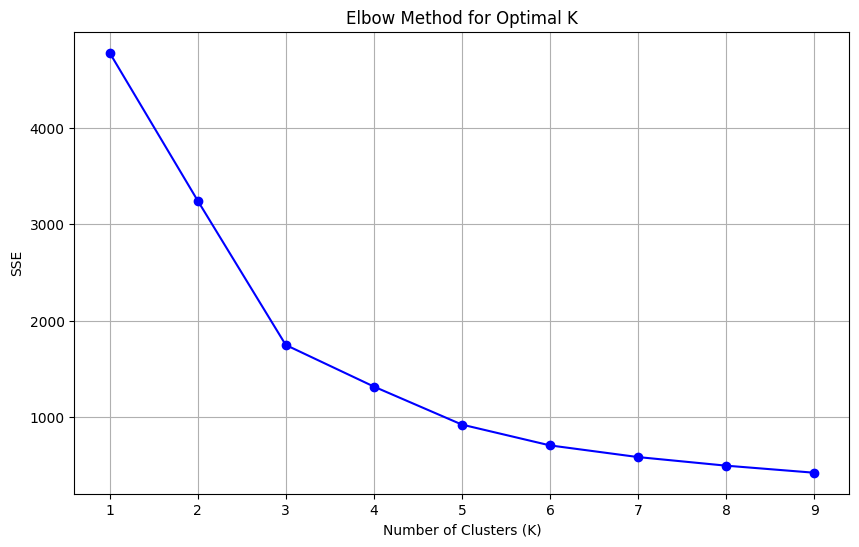

In [114]:
#elbow method
# Initialize a list to store SSE values for different K
sse = []

# Try different values of K (e.g., from 1 to 10)
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(selected_data)
    sse.append(kmeans.inertia_)
    print("k: " + str(k) + " SSE: " + str(kmeans.inertia_))

# Plot the SSE values for different K
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [115]:
#Silhouette coefficient
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(selected_data, clusters)

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.39036688275135784
